In [1]:
import pickle
import sys
import os
sys.path.append("..")
from copy import deepcopy

from tqdm import tqdm
import h5py

import torch
import pytorch_lightning as pl
import pandas as pd

import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from argparse import Namespace
from datetime import datetime
from torchmetrics import MeanSquaredError

In [4]:
from hpl.utils.postprocessing import (
    find_experiments_directories, 
    load_data_assimilation_network, 
    load_hydra_config,
    dictconfig_to_dataframe,
    reconstruct_observations,
)
from hpl.datamodule.DataLoader import L96InferenceDataset
from hpl.datamodule.observational_models import RandomObservationModel
from hpl.scripts.test_data_assimilation_encoder import mesh_test_single_model

# Find best weak and strong constraint models

In [5]:
base_dir = "/gpfs/work/zinchenk/final_experiments/120324_try_batch_norm/"
test_data_path = "/gpfs/home/zinchenk/dev/hidden-process-learning/data/test/lorenz-one_level-grid_40-forcing_8.0-dt_0.01-rk4.h5"
random_seed = 2510
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
with h5py.File(test_data_path) as file:
    test_simulations = torch.from_numpy(file["first_level"][:]).to(device)

In [7]:
hyda_experiments = find_experiments_directories([base_dir])

In [64]:
# def reconstruct_observations(dataset, assimilation_network, verbose=False):
#     reconstractions = []
#     iterator = tqdm(dataset) if verbose else dataset
#     with torch.no_grad():
#         for batch in iterator:
#             reconstructed_state = assimilation_network.forward(batch)
#             reconstractions.append(reconstructed_state)
#     reconstractions = torch.stack(reconstractions, dim=-2).squeeze()
#     return reconstractions

In [65]:
def main(hydra_experiment: str, device: str):
    assimilation_network = load_data_assimilation_network(hydra_experiment, device=device)
    config = load_hydra_config(hydra_experiment)
    results_frame = dictconfig_to_dataframe(config)
    results_frame.insert(0, "experiment_dir", hydra_experiment, False)
    
    torch.manual_seed(random_seed)
    pl.seed_everything(random_seed)

    observational_model = RandomObservationModel(
        additional_noise_std=config.datamodule.dataset.additional_noise_std,
        random_mask_fraction=config.datamodule.dataset.random_mask_fraction,
    )
    dataset = L96InferenceDataset(
        ground_truth_data=test_simulations,
        observation_model=observational_model,
        input_window_extend=config.input_window_extend,
        drop_edge_samples=True,
    )
    
    reconstructions = reconstruct_observations(dataset, assimilation_network)
    ground_truth = dataset.ground_truth[:, config.input_window_extend:-config.input_window_extend+1]
    squered_errors = (reconstructions - ground_truth)**2
    rmse_per_test_case = squered_errors.mean((-1, -2)).sqrt()
    
    results_frame.insert(0, "min_rmse", rmse_per_test_case.min().cpu().item(), False)
    results_frame.insert(0, "max_rmse", rmse_per_test_case.max().cpu().item(), False)
    results_frame.insert(0, "mean_rmse", rmse_per_test_case.mean().cpu().item(), False)
    results_frame.insert(0, "std_rmse", rmse_per_test_case.std().cpu().item(), False)
       
    return results_frame

In [66]:
results = []
for experiment in tqdm(hyda_experiments):
    res = main(experiment, device)
    results.append(res)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [12:43<00:00, 18.18s/it]


In [67]:
df = pd.concat(results, ignore_index=True)
df.to_pickle("different_alpha_values_plot")

In [8]:
df = pickle.load(open("different_alpha_values_plot", "rb"))

In [9]:
df.rollout_length.unique()

array([ 1, 25, 10])

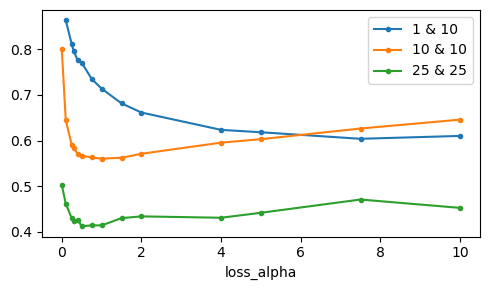

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

df[(df.rollout_length == 1) & (df.loss_alpha > 0)].sort_values("loss_alpha").plot(
    x="loss_alpha", 
    y="mean_rmse", 
    label="1 & 10",
    marker="o",
    ms=3,
    ax=ax, 
)
df[df.rollout_length == 10].sort_values("loss_alpha").plot(
    x="loss_alpha", 
    y="mean_rmse", 
    label="10 & 10", 
    marker="o",
    ms=3,
    ax=ax,
)
df[df.rollout_length == 25].sort_values("loss_alpha").plot(
    x="loss_alpha", 
    y="mean_rmse", 
    label="25 & 25", 
    marker="o",
    ms=3,
    ax=ax,
)

plt.tight_layout()
plt.savefig("alpha_plots.png", dpi=300)

In [11]:
def find_best_model(df: pd.DataFrame):
    return df[df.mean_rmse == df.mean_rmse.min()]

In [68]:
checkpoint_best_weak = find_best_model(df[df.rollout_length == 25])["experiment_dir"].item()
checkpoint_best_weak

'/gpfs/work/zinchenk/final_experiments/120324_try_batch_norm/data_assimilation/multirun/2024-03-12/22-03-06/5'

In [13]:
checkpoint_best_strong = find_best_model(df[(df.rollout_length == 25) & (df.loss_alpha == 0)])["experiment_dir"].item()
checkpoint_best_strong

'/gpfs/work/zinchenk/final_experiments/120324_try_batch_norm/data_assimilation/multirun/2024-03-12/22-03-06/0'

# Mesh test for best strong constraint model

In [14]:
device = torch.device("cuda")

test_data_dir = "/gpfs/home/zinchenk/dev/hidden-process-learning/data/test/lorenz-one_level-grid_40-forcing_8.0-dt_0.01-rk4.h5"
experiment_dir = checkpoint_best_strong
n_simulations = 25
noise_std_min = 0.1
noise_std_max = 3.0
mask_fraction_min = 0.1
mask_fraction_max = 0.9
mesh_steps = 15
ignore_edges = True
output_directory = "/gpfs/home/zinchenk/dev/hidden-process-learning/notebooks/"
n_jobs = 10
seed = 101

In [15]:
timestamp = datetime.now().strftime("%Y-%d-%m-%H-%M")
output_directory = os.path.join(output_directory, timestamp)
os.makedirs(output_directory)

In [16]:
args = Namespace(
    data_path=test_data_dir,
    experiment_dir=experiment_dir,
    output_dir=output_directory,
    noise_std_min=noise_std_min,
    noise_std_max=noise_std_max,
    mask_fraction_min=mask_fraction_min,
    mask_fraction_max=mask_fraction_max,
    mesh_steps=mesh_steps,
    seed=seed,
    n_simulations=n_simulations,
    device=str(device),
    ignore_edges=ignore_edges,
    n_jobs=n_jobs,
)

mesh_test_single_model(args, experiment_dir)

/gpfs/work/zinchenk/lib/miniconda3/envs/hpl-torch/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402374358/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [12:03<00:00,  3.21s/it]


# Mesh test for best weak constraint model

In [17]:
device = torch.device("cuda")

test_data_dir = "/gpfs/home/zinchenk/dev/hidden-process-learning/data/test/lorenz-one_level-grid_40-forcing_8.0-dt_0.01-rk4.h5"
experiment_dir = checkpoint_best_weak
n_simulations = 25
noise_std_min = 0.1
noise_std_max = 3.0
mask_fraction_min = 0.1
mask_fraction_max = 0.9
mesh_steps = 15
ignore_edges = True
output_directory = "/gpfs/home/zinchenk/dev/hidden-process-learning/notebooks/"
n_jobs = 10
seed = 101

In [18]:
timestamp = datetime.now().strftime("%Y-%d-%m-%H-%M")
output_directory = os.path.join(output_directory, timestamp)
os.makedirs(output_directory)

In [19]:
args = Namespace(
    data_path=test_data_dir,
    experiment_dir=experiment_dir,
    output_dir=output_directory,
    noise_std_min=noise_std_min,
    noise_std_max=noise_std_max,
    mask_fraction_min=mask_fraction_min,
    mask_fraction_max=mask_fraction_max,
    mesh_steps=mesh_steps,
    seed=seed,
    n_simulations=n_simulations,
    device=str(device),
    ignore_edges=ignore_edges,
    n_jobs=n_jobs,
)

mesh_test_single_model(args, experiment_dir)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [11:15<00:00,  3.00s/it]


# Plotting

In [44]:
simulations = test_simulations[:n_simulations]

experiment_dir_strong = "/gpfs/work/zinchenk/final_experiments/120324_try_batch_norm/data_assimilation/multirun/2024-03-12/22-03-06/0"
experiment_dir_weak = "/gpfs/work/zinchenk/final_experiments/120324_try_batch_norm/data_assimilation/multirun/2024-03-12/22-03-06/5"

config_strong = load_hydra_config(experiment_dir_strong)
config_weak = load_hydra_config(experiment_dir_weak)

output_directory_strong = "/gpfs/home/zinchenk/dev/hidden-process-learning/notebooks/2024-30-04-11-57"
output_directory_weak = "/gpfs/home/zinchenk/dev/hidden-process-learning/notebooks/2024-30-04-12-10"

In [45]:
def prepare_mesh_plot(config, output_directory, simulations):
    rmse_dict = dict(
        noise_std=[],
        mask_fraction=[],
        rmse=[],
    )

    rmse_func = MeanSquaredError(squared=False)
    output_files = os.listdir(output_directory)
    for output in tqdm(output_files):
        path_to_file = os.path.join(output_directory, output)
        ground_truth = simulations
        with h5py.File(path_to_file, "r") as file:
            ignore_edges = file.attrs["ignore_edges"]
            experiment_dir = file.attrs["experiment_dir"]
            rmse_dict["noise_std"].append(file.attrs["noise_std"])
            rmse_dict["mask_fraction"].append(file.attrs["mask_fraction"])
            reconstruction = torch.from_numpy(file["reconstruction"][:])
            if ignore_edges:
                config = load_hydra_config(experiment_dir)
                input_window_extend = config.datamodule.dataset.input_window_extend
                ground_truth = simulations[:, input_window_extend:-input_window_extend + 1].cpu()
            avg_rmse = [rmse_func(reconstruction[i], ground_truth[i]) for i in range(reconstruction.size(0))]
            avg_rmse = torch.tensor(avg_rmse).mean().item()
            rmse_dict["rmse"].append(avg_rmse)

    rmse_frame = pd.DataFrame(rmse_dict)
    rmse_frame.sort_values(["noise_std", 'mask_fraction'], inplace=True)
    return rmse_frame

In [46]:
df_strong = prepare_mesh_plot(config_strong, output_directory_strong, simulations)
df_weak = prepare_mesh_plot(config_weak, output_directory_weak, simulations)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 225/225 [00:16<00:00, 13.80it/s]


In [47]:
noise_std_flatten = df_strong.noise_std.values
mask_fraction_flatten = df_strong.mask_fraction.values
rmse_flatten = df_strong.rmse.values

noise_mesh = noise_std_flatten.reshape(mesh_steps, mesh_steps)
mask_fracton_mesh = mask_fraction_flatten.reshape(mesh_steps, mesh_steps)
rmse_mesh_strong = rmse_flatten.reshape(mesh_steps, mesh_steps)

In [48]:
noise_std_flatten = df_weak.noise_std.values
mask_fraction_flatten = df_weak.mask_fraction.values
rmse_flatten = df_weak.rmse.values

noise_mesh = noise_std_flatten.reshape(mesh_steps, mesh_steps)
mask_fracton_mesh = mask_fraction_flatten.reshape(mesh_steps, mesh_steps)
rmse_mesh_weak = rmse_flatten.reshape(mesh_steps, mesh_steps)

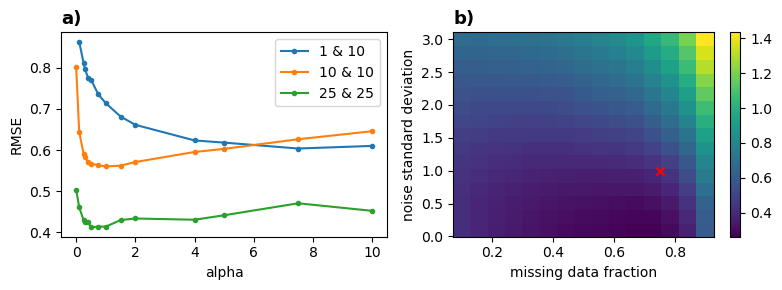

In [65]:
mosaic = """
ab
"""
fig, axd = plt.subplot_mosaic(mosaic=mosaic, figsize=(8, 3))

df[(df.rollout_length == 1) & (df.loss_alpha > 0)].sort_values("loss_alpha").plot(
    x="loss_alpha",
    y="mean_rmse",
    label="1 & 10",
    marker="o",
    ms=3,
    ax=axd["a"],
)
df[df.rollout_length == 10].sort_values("loss_alpha").plot(
    x="loss_alpha",
    y="mean_rmse",
    label="10 & 10",
    marker="o",
    ms=3,
    ax=axd["a"],
)
df[df.rollout_length == 25].sort_values("loss_alpha").plot(
    x="loss_alpha",
    y="mean_rmse",
    label="25 & 25",
    marker="o",
    ms=3,
    ax=axd["a"],
)

axd["a"].set_xlabel("alpha")
axd["a"].set_ylabel("RMSE")

img = axd["b"].pcolor(mask_fracton_mesh[0, :], noise_mesh[:, 0], rmse_mesh_weak, cmap="viridis")
plt.colorbar(img)
axd["b"].scatter(0.75, 1.0, marker='x', color="red")
axd["b"].set_xlabel("missing data fraction")
axd["b"].set_ylabel("noise standard deviation")

for letter, ax in axd.items():
    ax.set_title(f"{letter})", loc="left", fontsize=13, fontweight="bold")

plt.tight_layout()
plt.savefig("data_assimilation_generalization.png", dpi=300)